In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('294_satellite_image', return_X_y=True)

In [5]:
X.shape

(6435, 36)

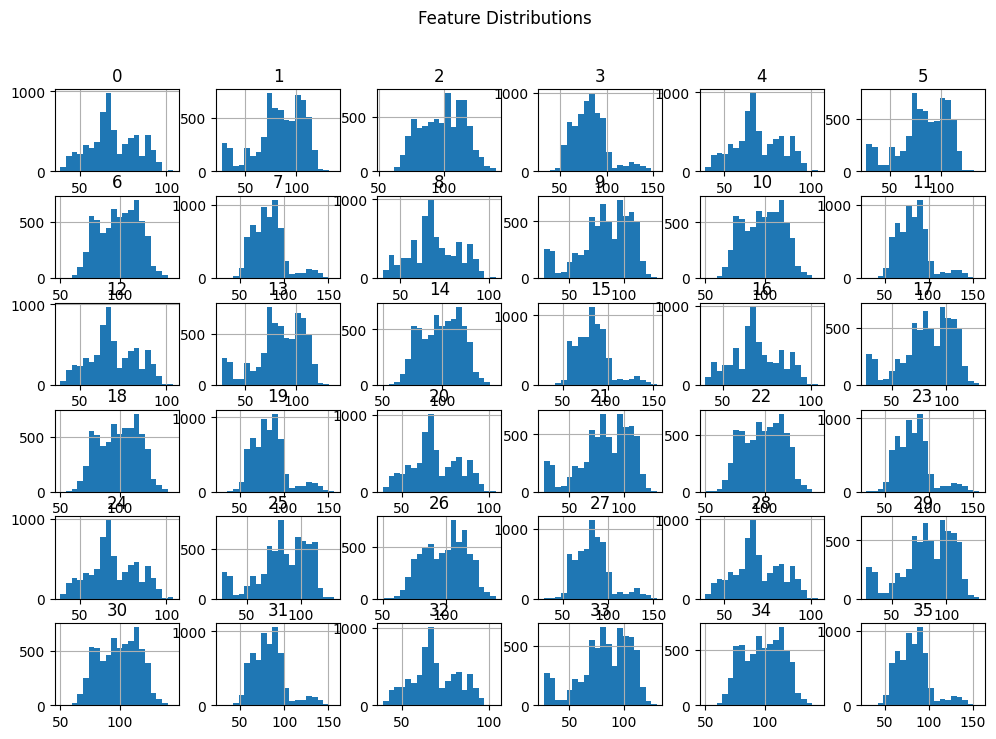

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

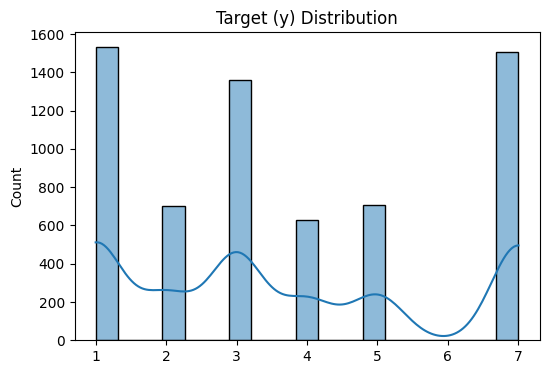

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

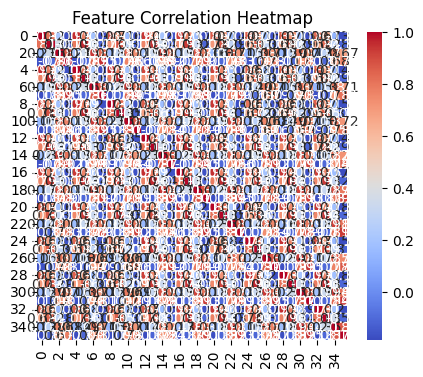

In [8]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.744152                 2.113133             1.259497   
1                  1.672823                 1.595743             1.878513   
2                  1.979987                 1.539545             2.367425   
3                  1.726427                 1.610832             1.808218   
4                  1.716858                 1.873965             1.506570   
mean               1.768049                 1.746644             1.764045   
std                0.121357                 0.242194             0.418325   

      DefaultBART_Rhat_RMSE  
0                  2.174108  
1                  1.556557  
2                  1.818061  
3                  1.824074  
4                  2.390115  
mean               1.952583  
std                0.328617  


In [10]:
rhat_df.to_csv("results/real7_Satellite_rhat.csv", index=False)

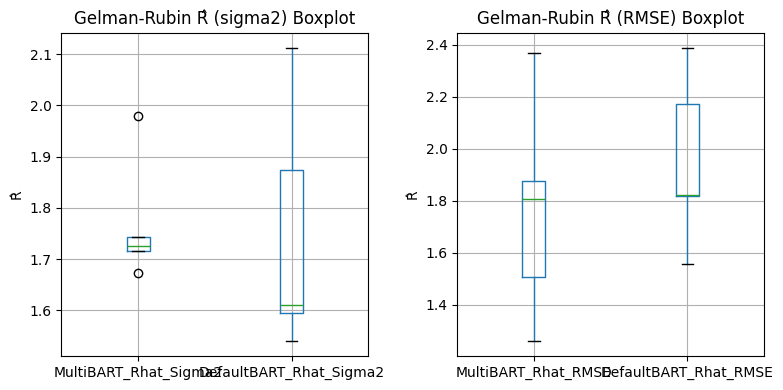

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      0.565230  0.635462  0.591074  0.985161  0.489757  0.534697
1      0.615326  0.657226  0.636560  0.972973  0.539908  0.580095
2      0.578322  0.592937  0.612303  1.046699  0.483001  0.500649
3      0.649036  0.594618  0.681149  0.949543  0.556418  0.575852
4      0.594738  0.590226  0.602730  1.024191  0.483305  0.504522
5      0.611119  0.613397  0.628348  0.990226  0.503560  0.567139
6      0.657360  0.582452  0.615198  0.901395  0.507003  0.555896
7      0.569030  0.572687  0.587208  1.018400  0.489314  0.524277
8      0.604514  0.599180  0.622374  0.925338  0.519927  0.507214
9      0.573996  0.651589  0.645796  0.874229  0.479440  0.539197
mean   0.601867  0.608977  0.622274  0.968816  0.505163  0.538954
std    0.032285  0.029432  0.027879  0.055865  0.026199  0.029869



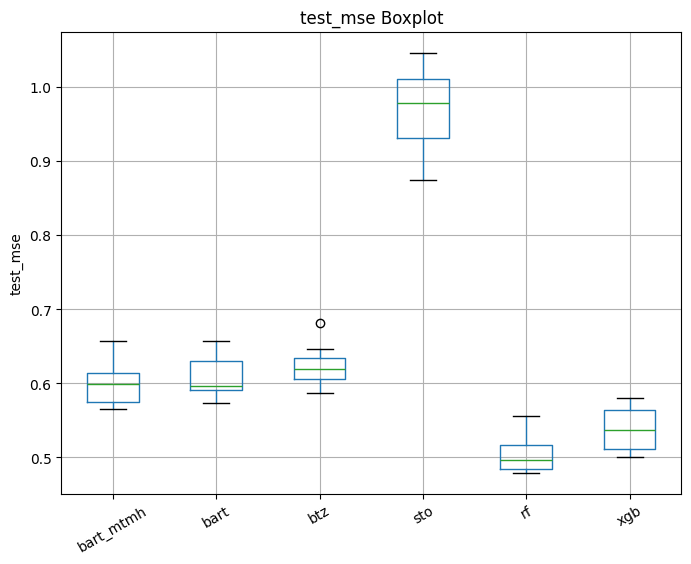

train_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      0.116724  0.265179  0.349395  0.789651  0.071356  0.011611
1      0.111210  0.265654  0.321582  0.782341  0.068218  0.011267
2      0.129070  0.275564  0.349185  0.943803  0.071901  0.011581
3      0.110796  0.270577  0.308020  0.860463  0.067736  0.011723
4      0.127301  0.296493  0.348839  0.876690  0.067946  0.010618
5      0.111536  0.281455  0.346854  0.826642  0.069954  0.010860
6      0.118362  0.277629  0.342673  0.773057  0.070489  0.013329
7      0.116432  0.278662  0.342481  0.893304  0.068721  0.012514
8      0.120271  0.275009  0.317211  0.787818  0.070691  0.013440
9      0.122371  0.284693  0.348305  0.797477  0.067813  0.011853
mean   0.118407  0.277092  0.337454  0.833125  0.069483  0.011880
std    0.006461  0.009297  0.015622  0.057696  0.001579  0.000951



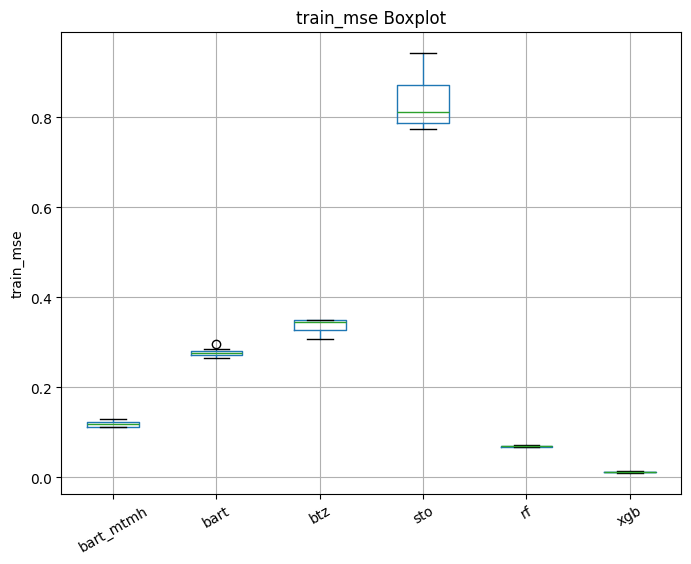

pi_length:
      bart_mtmh      bart       btz           sto
0      1.749009  2.281343  2.857513  1.047379e+03
1      1.745644  2.305471  2.792392  2.638187e+02
2      1.817626  2.366011  2.938963  2.971376e+06
3      1.687347  2.346017  2.741731  4.387006e+12
4      1.839238  2.425267  2.881210  3.077686e+07
5      1.712976  2.387384  2.858659  6.419434e+04
6      1.748352  2.370238  2.850220  5.422141e+01
7      1.745834  2.358365  2.848243  5.013718e+03
8      1.804653  2.373129  2.794599  1.228613e+03
9      1.811685  2.374282  2.848382  1.209216e+03
mean   1.766236  2.358751  2.841191  4.387040e+11
std    0.049474  0.040648  0.054119  1.387292e+12



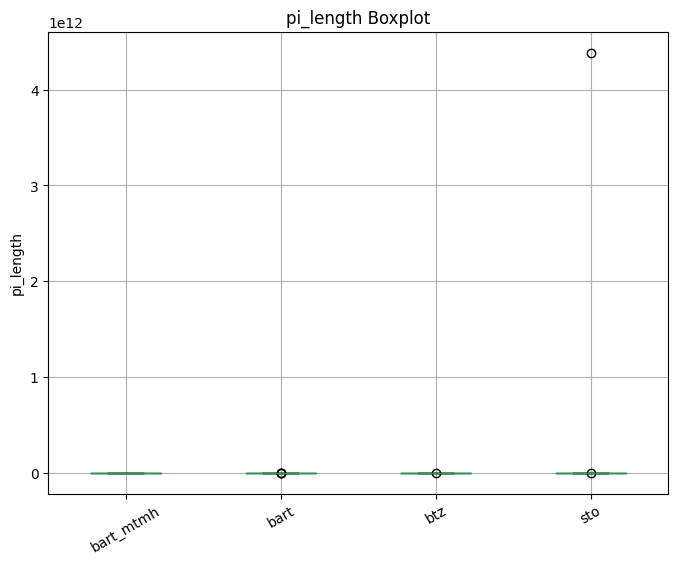

coverage:
      bart_mtmh      bart       btz       sto
0      0.850218  0.880050  0.925420  0.875699
1      0.850218  0.893723  0.908639  0.868241
2      0.858919  0.893101  0.920447  0.929770
3      0.844002  0.899316  0.908017  0.977004
4      0.855190  0.899316  0.922312  0.939093
5      0.829708  0.897452  0.925420  0.935985
6      0.835923  0.891858  0.909260  0.855811
7      0.841516  0.891237  0.921690  0.875699
8      0.857054  0.896830  0.916718  0.978247
9      0.863269  0.885643  0.917961  0.895587
mean   0.848602  0.892853  0.917589  0.913114
std    0.010702  0.006154  0.006765  0.044974



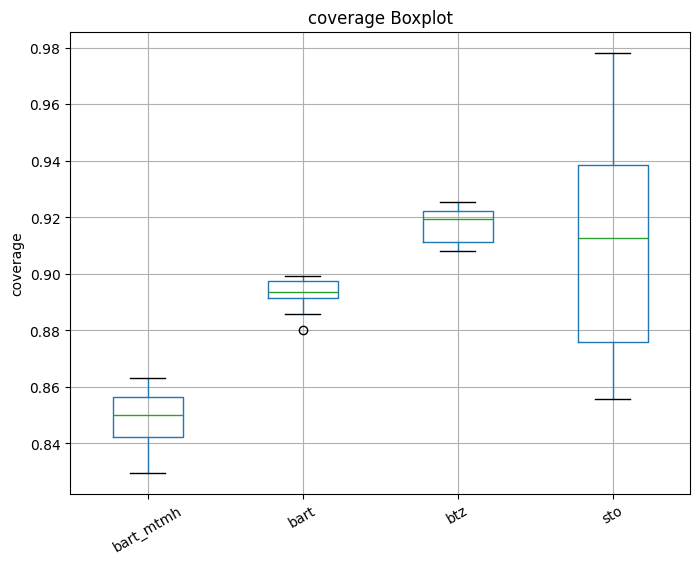

train_time:
       bart_mtmh       bart        btz        sto        rf       xgb
0     228.929478  26.659092  34.703123  60.968722  4.057940  0.202562
1     232.478146  30.480364  38.440580  56.522386  4.084843  0.195268
2     226.571928  26.912472  32.523599  60.163521  3.968713  0.217753
3     229.791847  26.644907  35.721187  60.044950  4.097181  0.178838
4     228.560143  26.808856  34.134542  58.938743  4.016707  0.181932
5     237.927486  29.160501  24.203919  66.576956  3.903877  0.115758
6     239.285276  29.907462  26.676320  62.385854  4.077874  0.108690
7     237.844834  30.293331  27.420609  60.742620  4.129473  0.108516
8     240.242926  37.392107  26.813791  57.853680  4.024233  0.116983
9     235.378370  38.416443  28.003884  57.089332  4.173812  0.107834
mean  233.701044  30.267553  30.864155  60.128676  4.053465  0.153413
std     5.040121   4.319575   4.801865   2.917390  0.078554  0.045467



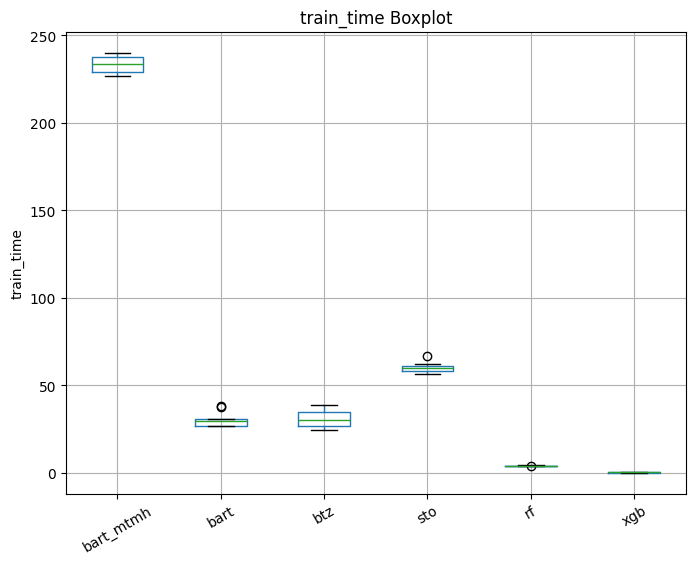

In [ ]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [10]:
for k, v in mse_results.items():
    csv_name = f"results/real7_Satellite_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real7_Satellite_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50, 100],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real7_Satellite_tries.csv", index=False)

In [ ]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage  Train_Time
0            1     1.784598   1.672395  0.615097  0.890740   62.543055
1            5     1.767612   1.949250  0.608540  0.867122  150.839366
2           10     1.768049   1.764045  0.592111  0.857800  240.953483
3           50     2.003316   2.100155  0.614439  0.806215  991.665675
